In [2]:
from utils import align_face, face_morph
from PIL import Image
import projector
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt	
from scipy.interpolate import CubicSpline

/Users/oliverlundin/miniforge3/envs/facemorphing/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
anna_path = 'images/anna.jpg'
filip_path = 'images/filip.jpg'
emma_path = 'images/emma.jpg'
oliver_path = 'images/oliver.jpg'
image_paths = [anna_path, filip_path, emma_path, oliver_path]

In [4]:
# create a list of all the image paths
aligned_faces = []	
for path in image_paths:
	path = Image.open(path)
	aligned_faces.append(align_face(path))


In [5]:
# convert every image to numpy array
aligned_faces = [np.array(face) for face in aligned_faces]

# convert every image to a tensor
aligned_faces = [torch.tensor(face) for face in aligned_faces]

# put the last dimension first
aligned_faces = [face.permute(2, 0, 1) for face in aligned_faces]

# check the shape of all the faces
for face in aligned_faces:
	print(face.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [6]:
# Set device
if(torch.backends.mps.is_available()): # True
    print("MPS is available")
    device = torch.device("mps")


# Load the generator model from the pickle file
with open('ffhq_res256.pkl', 'rb') as f:
	G = pickle.load(f)['G_ema'].to(device) 
      


MPS is available


In [7]:
# project the images to the latent space
latent = []
for face in aligned_faces:
	latent.append(projector.project(G, target=face, num_steps=4, device=device, verbose=True))

print(latent)

Computing W midpoint and stddev using 10000 samples...
step    1/4: dist 0.59 loss 15496.23
step    2/4: dist 0.54 loss 35369.52
step    3/4: dist 0.45 loss 29469.19
step    4/4: dist 0.42 loss 20930.67
Computing W midpoint and stddev using 10000 samples...
step    1/4: dist 0.72 loss 3999.42
step    2/4: dist 0.52 loss 2872.44
step    3/4: dist 0.45 loss 7518.68
step    4/4: dist 0.42 loss 4857.93
Computing W midpoint and stddev using 10000 samples...
step    1/4: dist 0.59 loss 12674.16
step    2/4: dist 0.54 loss 6810.22
step    3/4: dist 0.50 loss 8597.00
step    4/4: dist 0.43 loss 4544.80
Computing W midpoint and stddev using 10000 samples...
step    1/4: dist 0.55 loss 11351.66
step    2/4: dist 0.55 loss 36872.29
step    3/4: dist 0.48 loss 33270.52
step    4/4: dist 0.41 loss 24329.42
[tensor([[[ 0.3648,  0.0354,  0.0826,  ...,  0.2412,  0.4028, -0.0132],
         [ 0.3648,  0.0354,  0.0826,  ...,  0.2412,  0.4028, -0.0132],
         [ 0.3648,  0.0354,  0.0826,  ...,  0.2412, 

In [20]:
squeezed = []

for projection in latent:
	squeezed.append(projection[-1].unsqueeze(0))

print(len(squeezed))
print(type(squeezed[0]))

4
<class 'torch.Tensor'>


In [21]:
# i want to linearly interpolate between the values of squeezed, in a football bracket style
import torch

def interpolate_bracket(tensor_list, t=0.5):
    """
    Perform linear interpolation between consecutive tensors in the list.
    
    Args:
    - tensor_list (list of torch.Tensors): List of 3D tensors to interpolate between.
    - t (float): Interpolation factor (default is 0.5 for mid-point interpolation).
    
    Returns:
    - interpolated_list (list of torch.Tensors): List of interpolated tensors.
    """
    interpolated_list = []
    
    # Loop through consecutive pairs of tensors
    for i in range(len(tensor_list) - 1):
        tensor_a = tensor_list[i]
        tensor_b = tensor_list[i + 1]
        
        # Perform linear interpolation
        interpolated_tensor = (1 - t) * tensor_a + t * tensor_b
        
        # Append the result to the list
        interpolated_list.append(interpolated_tensor)
    
    return interpolated_list




In [22]:
# Perform interpolation with multiple steps between each pair

# loop through all the squeezed tensors
# interpolate between each pair of tensors
# append the interpolated tensors to a list
# repeat the process until we have a single tensor
print(len(squeezed))
all_interpolated_tensors = [] 

while len(squeezed) > 1:
	# Interpolate between each pair of tensors
	squeezed = interpolate_bracket(squeezed, t=0.5)
	
	# Update the list of tensors
	all_interpolated_tensors.append(squeezed)
      
	print(len(squeezed))
	


# Print the results
for i, tensor in enumerate(all_interpolated_tensors):
    print(f"Step {i + 1} Tensor:\n", tensor)

4
3
2
1
Step 1 Tensor:
 [tensor([[[ 0.2715,  0.0287,  0.3056,  ...,  0.3195,  0.4367, -0.0363],
         [ 0.2715,  0.0287,  0.3056,  ...,  0.3195,  0.4367, -0.0363],
         [ 0.2715,  0.0287,  0.3056,  ...,  0.3195,  0.4367, -0.0363],
         ...,
         [ 0.2715,  0.0287,  0.3056,  ...,  0.3195,  0.4367, -0.0363],
         [ 0.2715,  0.0287,  0.3056,  ...,  0.3195,  0.4367, -0.0363],
         [ 0.2715,  0.0287,  0.3056,  ...,  0.3195,  0.4367, -0.0363]]],
       device='mps:0'), tensor([[[ 0.2816, -0.0587,  0.3087,  ...,  0.2102,  0.4252, -0.1673],
         [ 0.2816, -0.0587,  0.3087,  ...,  0.2102,  0.4252, -0.1673],
         [ 0.2816, -0.0587,  0.3087,  ...,  0.2102,  0.4252, -0.1673],
         ...,
         [ 0.2816, -0.0587,  0.3087,  ...,  0.2102,  0.4252, -0.1673],
         [ 0.2816, -0.0587,  0.3087,  ...,  0.2102,  0.4252, -0.1673],
         [ 0.2816, -0.0587,  0.3087,  ...,  0.2102,  0.4252, -0.1673]]],
       device='mps:0'), tensor([[[ 0.2426, -0.1001,  0.2062,  ..., 

In [24]:
print(len(all_interpolated_tensors))


3


In [34]:
#all_interpolated_tensors is list of lists of tensors
#flatten the list of lists

all_interpolated_tensors = [tensor for sublist in all_interpolated_tensors for tensor in sublist]

# convert to a tensor
all_interpolated_tensors = torch.stack(all_interpolated_tensors)


#all_interpolated_tensors.to(device)


In [35]:

morphed_images = G.synthesis(all_interpolated_tensors, noise_mode='const', force_fp32=True)


In [36]:
print(morphed_images.shape)

torch.Size([6, 3, 256, 256])


In [37]:
# Convert the images to numpy arrays
morphed_images = (morphed_images + 1) * (255/2)
morphed_images = (morphed_images.permute(0, 2, 3, 1).clamp(0, 255).cpu().numpy()).astype(np.uint8)
print(morphed_images.shape)



(6, 256, 256, 3)


In [ ]:
print(type(morphed_images[1]))

In [40]:
# convert aligned_faces to numpy arrays
aligned_faces = [face.permute(1, 2, 0).cpu().numpy() for face in aligned_faces]

# insert aligned_faces into morphed_images first
morphed_images = np.insert(morphed_images, 0, aligned_faces, axis=0)

print(morphed_images.shape)

(10, 256, 256, 3)


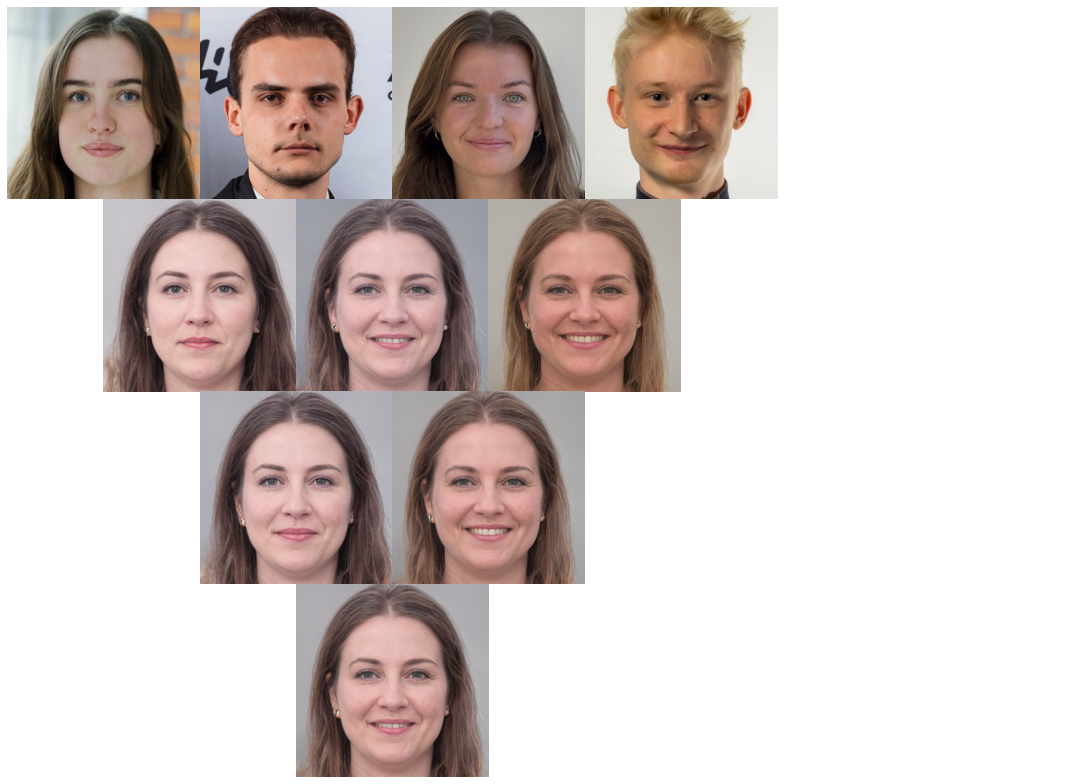

In [46]:
import matplotlib.pyplot as plt

# Number of images per row
rows_layout = [4, 3, 2, 1]

# Create a new figure
fig, ax = plt.subplots(figsize=(15, 15))

# Turn off the axis
ax.axis('off')

# Calculate the total width and height needed
total_width = max(rows_layout) + (len(rows_layout) - 1) * 0.5
total_height = len(rows_layout)

# Set the limits of the plot
ax.set_xlim(0, total_width)
ax.set_ylim(0, total_height)

# Index to track which image we are displaying
image_idx = 0

# Loop through the rows and display the corresponding number of images in each row
for row_idx, num_cols in enumerate(rows_layout):
    # Calculate the offset for this row
    row_offset = row_idx * 0.5
    
    for col_idx in range(num_cols):
        if image_idx < len(morphed_images):
            # Calculate the position for this image
            x = col_idx + row_offset
            y = total_height - row_idx - 1  # Invert y-axis for top-to-bottom layout
            
            # Add the image to the plot
            ax.imshow(morphed_images[image_idx], extent=[x, x+1, y, y+1], aspect='equal', cmap='gray')
            
            image_idx += 1

# Adjust the layout
plt.tight_layout()

# Display the images
plt.show()

In [231]:
# insert the aligned faces at every 6th position for the first 15 images

# convert aligned faces from PIL image to numpy arrays
aligned_faces = [np.array(face) for face in aligned_faces]




In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

def display_bracket_tree(images, morphs):
    """
    images: List of original images at the leaves (bottom level)
    morphs: List of lists, where each inner list contains morphed images for each level
            e.g., morphs[0] contains morphed images between pairs of original images,
                  morphs[1] contains morphed images between the next level of pairs.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Number of levels in the tree
    levels = len(morphs) + 1  # One extra level for original images

    # Display the bottom (original images)
    x_positions = np.linspace(0, 1, len(images))
    y_positions = np.zeros(len(images))  # Bottom level (level 0)

    for i, img in enumerate(images):
        im = OffsetImage(img, zoom=0.1)
        ab = AnnotationBbox(im, (x_positions[i], y_positions[i]), frameon=False)
        ax.add_artist(ab)

    # Display the morphed images (intermediate steps)
    for level in range(1, levels):
        # Calculate number of positions for this level (should be half of previous level)
        step = 2 ** level
        num_positions = len(images) // step
        x_positions = np.linspace(0, 1, num_positions)
        y_positions = np.full(num_positions, level)

        # Ensure we have enough morphed images to display
        if len(morphs[level - 1]) != num_positions:
            print(f"Warning: Mismatch in level {level}, expected {num_positions}, got {len(morphs[level - 1])}")

        # Plot the morphed images
        for i in range(num_positions):
            if i < len(morphs[level - 1]):  # Avoid out-of-bound error
                im = OffsetImage(morphs[level - 1][i], zoom=0.1)
                ab = AnnotationBbox(im, (x_positions[i], y_positions[i]), frameon=False)
                ax.add_artist(ab)

    ax.set_axis_off()
    plt.show()

# Call the function with aligned_faces as original images and morphed_images
display_bracket_tree(aligned_faces, morphed_images)
